In [1]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
import datetime as dt
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict
from sklearn.linear_model import LogisticRegression, Lasso
import seaborn as sns
import numpy as np
import utils
from Model import Model
import matplotlib.pyplot as plt
from tqdm import tqdm
from PrecisionMatrixBuilder import PrecisionMatrixBuilder
from Forecaster import Forecaster
from DataLoader import DataLoader
from PortfolioConstructor import PortfolioConstructor
from BackTester import BackTester

pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

Stellantis and WLN have a lot of missing prices compared to the other stocks in the CAC40: we exclude them from this analysis.

In [2]:
dataloader = DataLoader()
full_dataset, stock_names, time_index = dataloader.load_full_dataset_array()

[*********************100%***********************]  40 of 40 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [283]:
tscv = list(utils.time_series_cross_validation(full_dataset, time_index, n_splits=10, valid_size=66, test_size=66))

In [5]:
model_1 = Model("Lasso", "regression", Lasso(0.05))
model_2 = Model("LogisticRegression", "classification", LogisticRegression(C = 0.2, penalty="l1", solver="saga"))

In [6]:
models = [model_1, model_2]
config = utils.load_config()
alphas = config["alphas"]
thetas = config["thetas"]
lambdas = config["lambdas"]
capital = config["capital"]

In [7]:
returns = dataloader.load_returns()
precision_matrix_builder = PrecisionMatrixBuilder(returns = returns, window = 512, alphas = alphas, thetas = thetas)
prec_mat = precision_matrix_builder.get_precision_matrix()

100%|██████████| 2930/2930 [14:02<00:00,  3.48it/s]


In [8]:
benchmark_returns = dataloader.load_benchmark(date_index=time_index)
risk_free = dataloader.load_risk_free_rate(time_index)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [12]:
from Forecaster import Forecaster
forecaster = Forecaster(full_dataset, stock_names, time_index, valid_size=66, test_size=66, n_splits=10)
forecasts_valid, forecasts_test, weights_valid, weights_test, opt_param_dict, valid_index_full, test_index_full = forecaster.evaluate_test_models(models = models, prec_mat = prec_mat, lambdas = lambdas, alphas = alphas, thetas = thetas, capital = capital, stock_returns=returns, risk_free=risk_free, benchmark_returns=benchmark_returns)

10it [01:23,  8.37s/it]


In [13]:
weights_test_full_lasso = weights_test["Lasso"]
weights_test_full_logistic = weights_test["LogisticRegression"]

Text(0, 0.5, 'MSE')

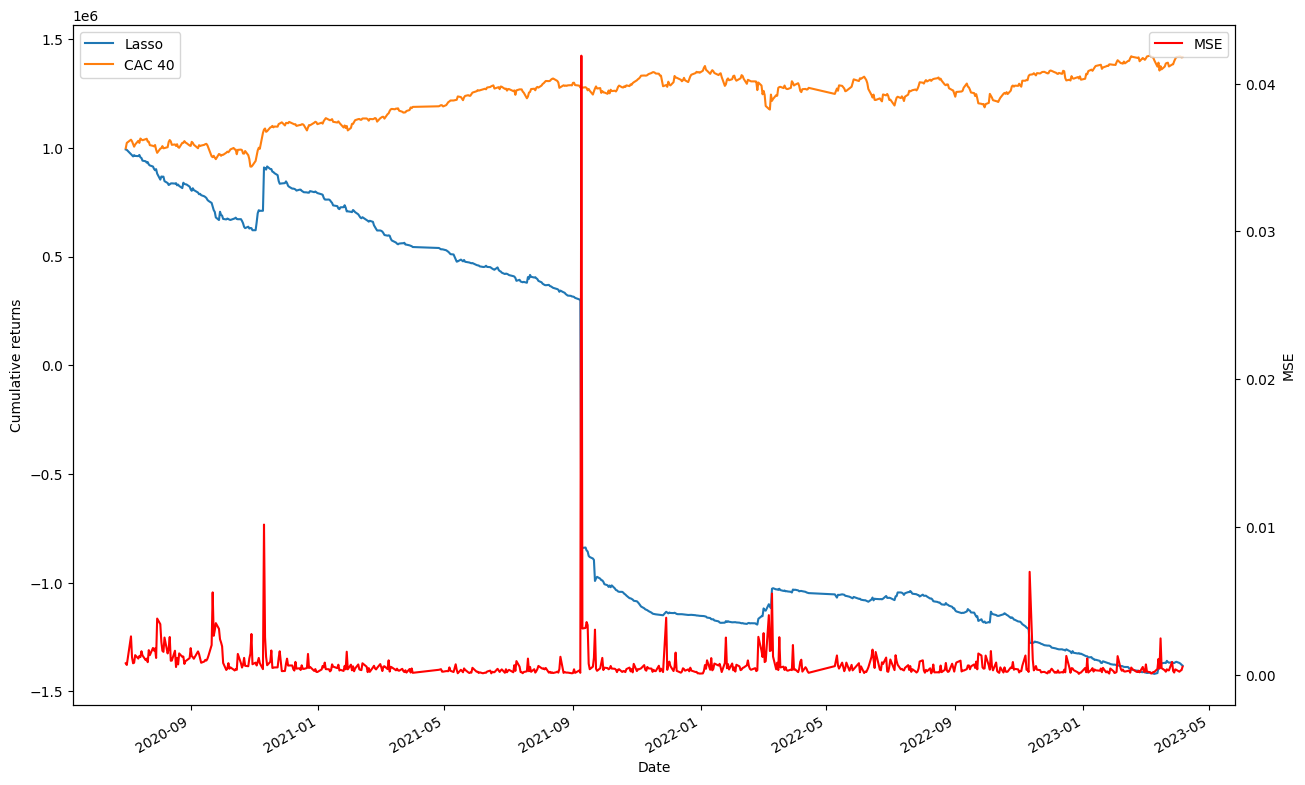

In [77]:
backtest = BackTester(weights_test_full_lasso, returns, capital, risk_free, benchmark=benchmark_returns, name = "Lasso")
backtest_statistics = backtest.get_backtest_statistics()
cum_returns = backtest.get_strategy_cumulative_returns()
cum_returns["MSE"] = (forecasts_test["Lasso"] - returns.loc[test_index_full, :]).apply(lambda x: x**2).mean(axis = 1)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
cum_returns.plot(y = ["Lasso", "CAC 40"], ax = ax1, figsize = (15, 10))
cum_returns.plot(y = "MSE", ax = ax2, color = "red")
ax1.set_ylabel("Cumulative returns")
ax2.set_ylabel("MSE")

In [70]:
backtest_statistics

Yearly excess returns         -0.910703
Yearly standard deviation      0.727739
Max DD                       321.137566
Yearly Sharpe                 -1.251414
Yearly Calmar                 -0.002836
Yearly Sortino                -1.114158
Daily Turnover                 0.567407
dtype: float64

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>], dtype=object)

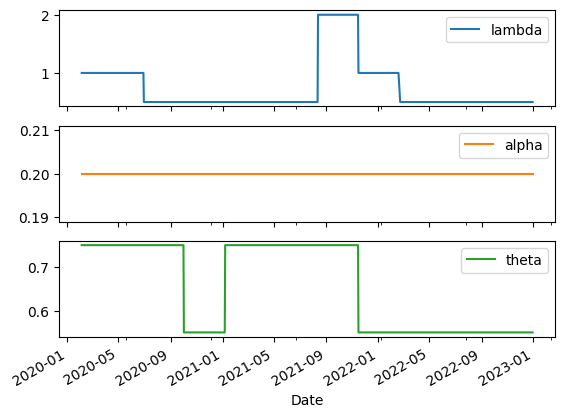

In [71]:
opt_param_dict["Lasso"].plot(subplots = True)

Text(0, 0.5, 'Misclassification rate')

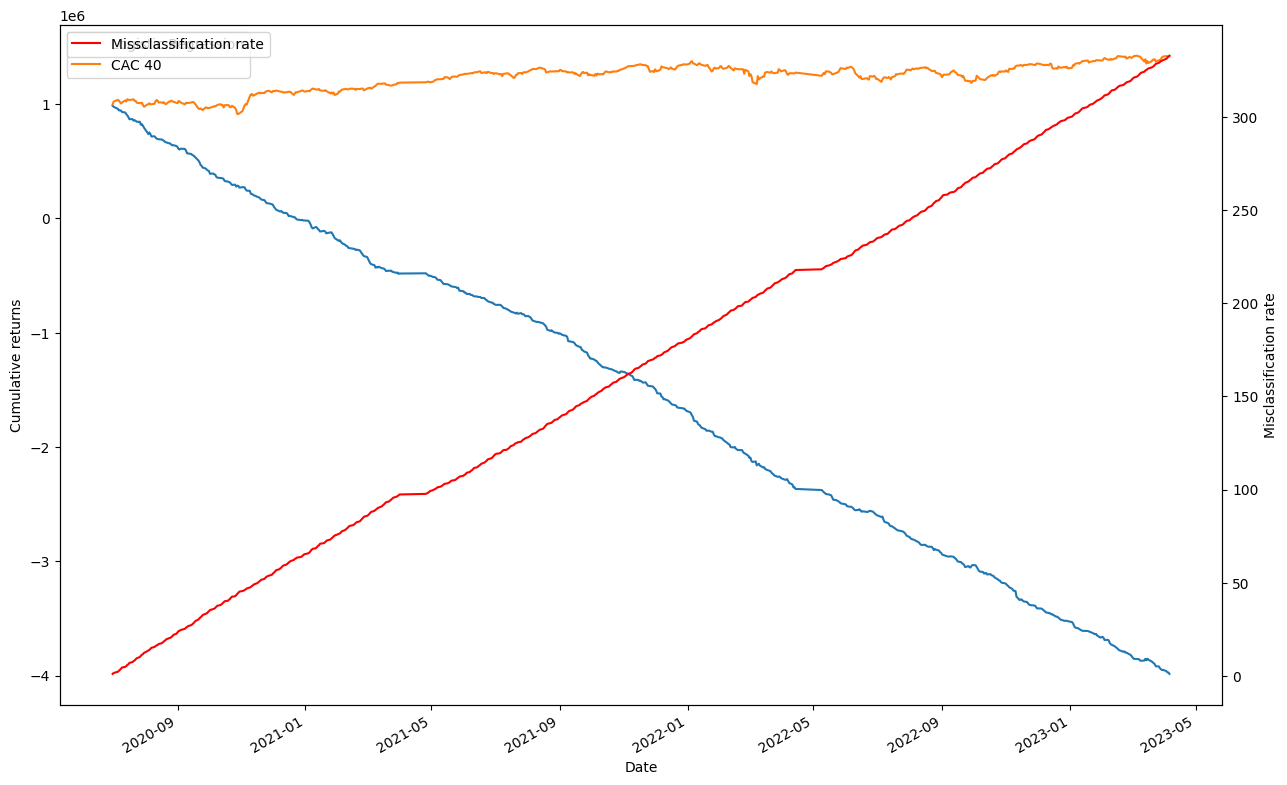

In [73]:
backtest = BackTester(weights_test_full_logistic, returns, capital, risk_free, benchmark = benchmark_returns, name = "Logistic Regression")
backtest_statistics = backtest.get_backtest_statistics()
cum_returns = backtest.get_strategy_cumulative_returns()
cum_returns["Missclassification rate"] = (forecasts_test["LogisticRegression"] != np.sign(returns.loc[test_index_full, :])).abs().mean(axis = 1).cumsum()

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
cum_returns.plot(y = ["Logistic Regression", "CAC 40"], ax = ax1, figsize = (15, 10))
cum_returns.plot(y = "Missclassification rate", ax = ax2, color = "red")
ax1.set_ylabel("Cumulative returns")
ax2.set_ylabel("Misclassification rate")

In [76]:
(forecasts_test["LogisticRegression"] != np.sign(returns.loc[test_index_full, :])).abs().mean(axis = 1).mean()

0.5041467304625202

In [74]:
backtest_statistics

Yearly excess returns         -1.906382
Yearly standard deviation      0.122541
Max DD                       383.393476
Yearly Sharpe                -15.557111
Yearly Calmar                 -0.004972
Yearly Sortino               -18.163180
Daily Turnover                 0.800806
dtype: float64